# Прогнозирование отказов двигателей

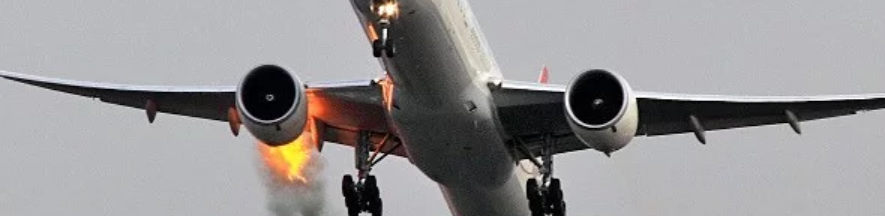

In [185]:
# БИБЛИОТЕКИ
import numpy as np
import pandas as pd
import plotly
import plotly.graph_objs as go
import plotly.figure_factory as ff
from tabulate import tabulate
from plotly.subplots import make_subplots
from IPython.display import HTML, display
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 50) # выведем больше колонок
import warnings; warnings.simplefilter('ignore') #  отключение вывода предупреждающих сообщений


# ФУНКЦИИ

def ds_inf(ds, column, index):
    ds.append([column
                , len(df)
                , df[column].dtype
                , round(len(df[df[column] != -1])/len(df)*100, 1)
                , len(df)-len(df[df[column] != -1])
                , str(df[column].min()) + ' - ' + str(df[column].max())
                , df[column].nunique()])
    return ds

def creating_wear(df):
    scaler = MinMaxScaler()
    engine_list = set(df['id'].to_list())
    
    rank = pd.DataFrame()
    for e in engine_list:
        tdf = df[df['id'] == e][['id', 'cycle']]
        tdf['wear'] = scaler.fit_transform(np.array(tdf['cycle']).reshape(-1,1))
        rank = pd.concat([rank, tdf], sort = False)
    df = pd.merge(df, rank, on = ['id', 'cycle'])
    return df

def normalisation(scaler, column):    
    df[column] = scaler.fit_transform(np.array(df[column]).reshape(-1,1))
    
def show_heatmap(df):
    corrs = df.corr()
    fig = ff.create_annotated_heatmap(z=corrs.values,
                                    x=list(corrs.columns),
                                    y=list(corrs.index),
                                    opacity=.8,
                                    annotation_text=corrs.round(2).values,
                                    showscale=True)
    fig.update_layout(title = 'Тепловая карта матрицы корреляций',
                     title_x = 0.5,
                     legend = dict(x = .5, xanchor = 'center', orientation = 'h'),
                     margin = dict(l=100, r=200, t=100, b=20))

    fig.show()


# Код, позволяющий скрывать ячейки
from IPython.display import HTML
import random

def hide_toggle(toggle_text = 'Toggle show/hide', for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

#    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle('Блок функций и библиотек')

### ПРЕДПОДГОТОВКА ДАННЫХ
### Содержание датафрейма

    id -- идентификатор мотора
    cycle -- цикл работы
    p00-p20 -- показания датчиков считываемые в процессе работы
    s0, s1 -- настройки изменяемые в конце каждого цикла


In [194]:
df = pd.read_csv('data.csv')

ds = [['Признак', '#', 'тип данных', '% заполнения', '# пропусков', 'диапазон значений', '# уникальных']]
columns_list = df.columns.to_list()
for col in columns_list:
    index = columns_list.index(col)
    ds = ds_inf(ds, col, index+1)
    
display(HTML(tabulate(ds[1:], headers = ds[0], tablefmt='html', showindex="always")))

print('\nКраткая сводка об исходном датасете:')
df.info(verbose = False)

df.drop(['p00', 'p01', 'p07', 'p09', 'p10', 'p16'], axis=1, inplace = True)
        
print('\nСодержание датасета после удаления столбцов:')
df.info(verbose = False)

,Признак,#,тип данных,% заполнения,# пропусков,диапазон значений,# уникальных
0,id,16138,int64,100,0,1 - 80,80
1,cycle,16138,int64,100,0,1 - 362,362
2,p00,16138,float64,100,0,518.67 - 518.67,1
3,p01,16138,float64,100,0,1.3 - 1.3,1
4,p02,16138,float64,100,0,46.86 - 48.53,156
5,p03,16138,float64,100,0,518.69 - 523.38,418
6,p04,16138,float64,100,0,2387.88 - 2388.56,56
7,p05,16138,float64,100,0,8099.94 - 8293.72,5707
8,p06,16138,float64,100,0,8.3249 - 8.5848,1871
9,p07,16138,float64,100,0,0.03 - 0.03,1



Краткая сводка об исходном датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Columns: 25 entries, id to s2
dtypes: float64(20), int64(5)
memory usage: 3.1 MB

Содержание датасета после удаления столбцов:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Columns: 19 entries, id to s2
dtypes: float64(16), int64(3)
memory usage: 2.3 MB


Исходный датасет содержит 25 числовых признаков. Пропусков нет. При оценке количества уникальных значений показаний, выявлены 6 датчиков, регистрирующих неизменные значения. В результате удаления из датасета столбцов с постоянными значениями, количество столбцов сократилось до 19. 

### Дополнительные признаки

Добавим признак состояния двигателя __wear__ проранжировав для каждого двигателя столбец __cycle__ в диапазоне от 0 до 1. Таким образом мы введем параметр, характеризующий степень механического износа агрегата. При достижении параметром __wear__ значения равного 1 происходит отказ агрегата (выход из строя).

Поскольку датасет не содержит информацию о показателях датчиков во время цикла, в котором произошел отказ, для проведения процедуры ранжирования ключевого показателя, дополним датасет информацией о циклах, в которых произошел отказ.

После выполнения ранжирования исключим дополнительные строки, не несущие в себе информации о показаниях датчиков.

Многие исследования, в которых изучается накопление механизмами физического износа, сходятся во мнении, что это процесс не является линейным. Дополним датафрейм параметром, полученным в результате возведения значения ранга цикла во вторую степень. Сохраним дополнительный параметр в переменной __p_wear__.

In [195]:
id_list = df['id'].unique().tolist()
temp_df = pd.DataFrame(columns = ['id', 'cycle'])
for i in id_list:
    temp_df.loc[i] = [i, df[df['id'] == i]['cycle'].max()+1] 

df = pd.concat([df, temp_df], sort = False)

df = creating_wear(df)
df['p2_wear'] = df['wear'].apply(lambda x: x**2)
df['p3_wear'] = df['wear'].apply(lambda x: x**3)
df.dropna(inplace = True)
print('\nДатасет после добавления ключевых переменных:')
df.info(verbose = False)


Датасет после добавления ключевых переменных:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16138 entries, 0 to 16137
Columns: 22 entries, id to p3_wear
dtypes: float64(20), object(2)
memory usage: 2.8+ MB



### Распределение продолжительности эксплуатации

Произведем подсчет количества циклов эксплуатации для представленных в датасете двигателей. 
Исследуем распределение сроков эксплуатации.

In [196]:
lifetime = df.pivot_table(index = 'id', values = 'wear', aggfunc = len).reset_index()

perc25 = lifetime['wear'].quantile(0.25)
perc75 = lifetime['wear'].quantile(0.75)
IQR = perc75 - perc25

fig = go.Figure()
fig = make_subplots(rows = 1, cols = 2)

fig.add_trace(go.Histogram(x = lifetime['wear'], name = 'histogram', opacity=.75),1,1)
fig.add_trace(go.Box(x = lifetime['wear'], name = 'box plot', boxpoints='all'),1,2)

fig.update_layout(title = 'Продолжительность периодов эксплуатации',
                 title_x = 0.5,
                 xaxis_title = 'Количество эксплуатационных циклов',
                 yaxis_title = 'Количество двигателей',
                 legend = dict(x = .5, xanchor = 'center', orientation = 'h'),
                 barmode = 'overlay',
                 margin = dict(l=100, r=100, t=30, b=0))
fig.show()

try:
    df.drop(['id', 'cycle'], axis=1, inplace = True)
except: True
        
print('\nСодержание датасета после удаления столбцов:')
df.info(verbose = False)


Содержание датасета после удаления столбцов:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 16138 entries, 0 to 16137
Columns: 20 entries, p02 to p3_wear
dtypes: float64(20)
memory usage: 3.2 MB


Выявлены 4-е наблюдения, лежащие за пределами доверительного интервала. Статистически эти наблюдения являются выбросами, однако, при обучении модели эти данные могут оказать положительное влияние.

После дополнения датасета ключевыми параметрами, характеризующими техническое состояние двигателей, а также после исследования продолжительности эксплуатации двигателей, можно удалить столбцы, определяющие количество циклов и содержащие идентификаторы двигателей, поскольку эти данные не могут быть использованы в обучении модели.

### Нормализация признаков

В целях подготовки данных к обучению модели, произведем нормализацию показаний датчиков и стандартизацию параметров применяемых настроек.

In [197]:
columns_list = df.columns.tolist()

scaler = MinMaxScaler()
for column in columns_list[:15]:
    normalisation(scaler, column)

scaler = StandardScaler()
for column in columns_list[15:17]:
    normalisation(scaler, column)

### Корреляционный анализ

In [198]:
show_heatmap(df)

В результате корреляционного анализа установлено:

* параметры настройки __s1__ и __S2__ не коррелируют с величиной условного износа агрегата, следовательно выбираются не зависимо от фактического технического состояния;
* показания датчика __p17__ имеют исчезающе низкую корреляцию с ключевыми показателями, параметр не имеет ценности для обучения модели;
* наименьшую корреляцию с ключевыми параметрами показывают датчики __p05__ и __p20__, при этом между собой они имеют корреляцию 0,97, в целях сокращения количества признаков, заменим их на произведение параметров, сохранив значение в колонке __p20.5__;
* наибольшую корреляцию с показаниями датчиков показал параметр __p3_wear__, используем его в качестве целевого парамера при обучении модели, остальные параметры (__wear__ и __p2_wear__) удалим.

Повторим построение корреляционной тепловой карты преобразованного датасета: 

In [199]:
df['p20.5'] = df.apply(lambda x: x['p05'] * x['p20'], axis = 1)
data = df[['p3_wear', 'p02', 'p03', 'p04', 'p06', 'p08', 'p11', 'p12', 'p13', 'p14', 'p15', 'p18', 'p19', 'p20.5']]

show_heatmap(data)

data.to_csv('Data_ML.csv')

Предподготовленный для обучения модели датасет сохранен в файле __"Data_ML.csv"__

## ОБУЧЕНИЕ МОДЕЛИ

### Деление датасета на части, необходимые для обучения и тестирования модели

In [200]:
df = pd.read_csv('Data_ML.csv')

# Х - значения зафиксированные датчиками, у - целевая переменная (параметр, характеризующий износ агрегата)
X = df.drop(['p3_wear'], axis = 1)
y = df['p3_wear']

# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Создание и обучение модели

In [203]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [204]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания значения износа агрегатов.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [205]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.059940543922452204


### Альтернативная задача для исследования датасета

##### Исследовать влияние выбираемых параметров настройки __s1__ и __s2__ на ресурс двигателя.